In [58]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm.notebook import tqdm
# from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
import re

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import random
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from warmup_scheduler import GradualWarmupScheduler

In [75]:
NUM_EPOCHS = 170
HIDDEN_SIZE = 300
EMBEDDING_DIM = 100
COORDINATES_DIM = 120
BATCH_SIZE = 3
NUM_HEADS = 4
NUM_LAYERS = 3
LEARNING_RATE = 0.002
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu") 
DROPOUT = 0.2
CLIP = 1.0
WARMUP_EPOCHS = 10
TRAIN_DIR = Path("./data_interior_4_train/")
TEST_DIR = Path("./data_interior_4_test/")
DROP_WORD_PROB = 0.15
DROP_CRD_PROB = 0.15

In [60]:
writer = SummaryWriter()

In [61]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, max_index):
        self.words = pd.read_csv(TRAIN_DIR/"vocab.csv", index_col=0)["0"].values.tolist()
        self.vocab = ["<pad>", "<sos>", "<eos>", "<unk>", "<mask>"] + self.words
        self.vocab_size = len(self.vocab)
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.block_size = 127
        self.max_index = max_index
        
    def __len__(self):
        return self.max_index
    
    def __getitem__(self, index):
        
        try:
            lst_tokens_src = np.loadtxt(
                             TRAIN_DIR/'entities_src_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()
            lst_tokens_trg = np.loadtxt(
                             TRAIN_DIR/'entities_trg_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()

            coord_tensor_src = torch.tensor(
                np.load(TRAIN_DIR/"coordinates_src_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
            coord_tensor_trg = torch.tensor(
                np.load(TRAIN_DIR/"coordinates_trg_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
        except:
            print(index, end = ", ")
            return ((torch.rand(2,2),torch.rand(2,2)), (torch.rand(2,2),torch.rand(2,2)))
        
        # for bert 
        sentence_src = ["<sos>"] + lst_tokens_src + lst_tokens_trg + ["<eos>"]
        sentence_trg = ["<sos>"] + lst_tokens_src + lst_tokens_trg + ["<eos>"]
        
        sentence_indices_src = [self.word_to_index[w] for w in sentence_src]
        sentence_indices_trg = [self.word_to_index[w] for w in sentence_trg]        
        
        for i, token in enumerate(sentence_indices_src):
            prob = random.random()
            if prob < DROP_WORD_PROB:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8:
                    sentence_indices_src[i] = self.word_to_index["<mask>"]

                # 10% randomly change token to random token
                elif prob < 0.9:
                    sentence_indices_src[i] = random.randrange(len(self.vocab))

        tokens_tenor_src = torch.tensor(sentence_indices_src).to(DEVICE)
        tokens_tenor_trg = torch.tensor(sentence_indices_trg).to(DEVICE)
        
        coord_tensor_trg_masked = coord_tensor_trg.clone()
        
        for i in range(coord_tensor_trg_masked.shape[0]):
            prob = random.random()
            if prob < DROP_CRD_PROB:
                coord_tensor_trg_masked[i,:] = torch.normal(0,1,[1,4])
        
        coord_padded_src = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_src,
            coord_tensor_trg_masked,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        coord_padded_trg = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_src,
            coord_tensor_trg,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        return ((tokens_tenor_src.unsqueeze(0).t(), coord_padded_src),
                (tokens_tenor_trg.unsqueeze(0).t(), coord_padded_trg))

In [62]:
l = [int(x[len("entities_src_"):][:-len(".txt")]) for x in 
        list(filter(None, 
        filter(lambda x: ".txt" in x and x != 'vocab.csv', 
               os.listdir(TRAIN_DIR))))]
max_index = max(l)
train_dataset = Dataset(max_index)

In [63]:
VOCAB_SIZE = train_dataset.vocab_size

In [64]:
class PadSequence:
    def __call__(self, batch):
        len_batch = len(batch)
        max_len_X = max([batch[i][0][0].shape[0] for i in range(len_batch)])
        max_len_y = max([batch[i][1][0].shape[0] for i in range(len_batch)])
        X_tok_batch = torch.zeros([1, max_len_X, 1], dtype = torch.int).to(DEVICE) 
        X_coord_batch = torch.zeros([1, max_len_X, 4]).to(DEVICE) 
        y_tok_batch = torch.zeros([1, max_len_y, 1], dtype = torch.int).to(DEVICE) 
        y_coord_batch = torch.zeros([1, max_len_y, 4]).to(DEVICE) 
        for i in range(len_batch):
            (X_tok, X_coord), (y_tok, y_coord) = batch[i]

            cur_len_X = X_tok.shape[0]
            cur_len_y = y_tok.shape[0]
            X_tok = torch.cat([
                            X_tok.to(DEVICE), 
                            torch.ones([max_len_X - cur_len_X, 1], dtype = torch.int).to(DEVICE) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            X_coord = torch.cat([X_coord.to(DEVICE), torch.zeros([max_len_X - cur_len_X, 4]).to(DEVICE)], dim = 0)
            y_tok = torch.cat([
                            y_tok.to(DEVICE), 
                            torch.ones([max_len_y - cur_len_y, 1], dtype = torch.int).to(DEVICE) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            y_coord = torch.cat([y_coord.to(DEVICE), torch.zeros([max_len_y - cur_len_y, 4]).to(DEVICE)], dim = 0)
            batch[i] = (X_tok, X_coord), (y_tok, y_coord)

            X_tok_batch = torch.cat([X_tok_batch, X_tok.unsqueeze(0)], dim = 0).to(DEVICE)
            X_coord_batch = torch.cat([X_coord_batch, X_coord.unsqueeze(0)], dim = 0).to(DEVICE)
            y_tok_batch = torch.cat([y_tok_batch, y_tok.unsqueeze(0)], dim = 0).to(DEVICE)
            y_coord_batch = torch.cat([y_coord_batch, y_coord.unsqueeze(0)], dim = 0).to(DEVICE)
            
        X_tok_batch = X_tok_batch[1:,:,:]
        X_coord_batch = X_coord_batch[1:,:,:]
        y_tok_batch = y_tok_batch[1:,:,:]
        y_coord_batch = y_coord_batch[1:,:,:]
        
        return (X_tok_batch, X_coord_batch), (y_tok_batch, y_coord_batch)

In [65]:
train_loader = DataLoader(train_dataset, shuffle=False, pin_memory=False,
                    batch_size=BATCH_SIZE,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [66]:
for batch in train_loader:
    break

In [67]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5, coord_dim: int = 4):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder_tok = nn.Embedding(ntoken, d_model - coord_dim)
        self.encoder_coord = nn.Linear(4, coord_dim)
        self.d_model = d_model
        self.decoder_tok = nn.Linear(d_model, ntoken)
        self.decoder_coord = nn.Linear(d_model, 4)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder_tok.weight.data.uniform_(-initrange, initrange)
        self.encoder_coord.bias.data.zero_()
        self.encoder_coord.weight.data.uniform_(-initrange, initrange)
        
        self.decoder_tok.bias.data.zero_()
        self.decoder_tok.weight.data.uniform_(-initrange, initrange)
        self.decoder_coord.bias.data.zero_()
        self.decoder_coord.weight.data.uniform_(-initrange, initrange)

    def forward(self, lst_arg) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        (X_tok, X_coord), (y_tok, y_coord) = lst_arg
        token_embeddings_src = self.encoder_tok(X_tok[:,:,0]) # [ bs, seq_len, emb ]
        coord_embeddings_src = self.encoder_coord(X_coord) # [ bs, seq_len, emb_coord ]
        src = torch.cat([token_embeddings_src, coord_embeddings_src], dim = 2)
        src = torch.transpose(src, 0,1) # [ seq_len, bs, emb+emb_coord ]
        
        src_key_padding_mask = (X_tok == 0)[:,:,0]
        
        src = src * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        output_tok = self.decoder_tok(output) # [ seq_len, bs, ntoken ]
        output_coord = self.decoder_coord(output) # [ seq_len, bs, 4 ]
        
        output_tok = output_tok.transpose(0,1) # [ bs, seq_len, ntoken ]
        output_coord = output_coord.transpose(0,1) # [ bs, seq_len, 4 ]
        
        return (output_tok, output_coord)

In [68]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1).to(DEVICE)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).to(DEVICE)
        pe = torch.zeros(max_len, 1, d_model).to(DEVICE)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [69]:
model = TransformerModel(VOCAB_SIZE, EMBEDDING_DIM+COORDINATES_DIM, 
                         NUM_HEADS, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, COORDINATES_DIM).to(DEVICE)

In [70]:
sum(p.numel() for p in model.parameters())

999569

In [71]:
criterion_tok = nn.CrossEntropyLoss(reduction="sum")
criterion_coord = nn.SmoothL1Loss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                 0.5, 10, 1e-6,'rel',
                                                 min_lr=0.00001,verbose=True)

In [ ]:
model.train()
n_iter = 0
lr = LEARNING_RATE
loss_trace = []
flag_warmup_updated = False
flag_normal_updated = False
for epoch in range(NUM_EPOCHS):
    current_loss = 0
    
    if epoch < WARMUP_EPOCHS:
        lr_mult = float(epoch) / float(max(1, WARMUP_EPOCHS))
        lr = LEARNING_RATE * lr_mult + LEARNING_RATE*0.0001
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    if epoch >= WARMUP_EPOCHS and flag_normal_updated == False:
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE
        flag_normal_updated = True
    
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        y_tok, y_coord = y
        b, t, _ = y_tok.size()

        logits_tok, pred_coord = model((x, y))
        
        loss_1 = criterion_tok(logits_tok.reshape(-1, logits_tok.size(-1)), y_tok.view(-1))
        loss_2 = (criterion_coord(pred_coord,y_coord) * (abs(y_coord) > 0.00001).int())\
                                .mean(0).sum(0).mean(0)
        loss_1 = loss_1 / b
        loss_2 = loss_2 / b
        loss = loss_1 + loss_2
        writer.add_scalar('Loss/cross_entropy', loss_1.item(), n_iter)
        writer.add_scalar('Loss/MSE', loss_2.item(), n_iter)
        writer.add_scalar('Loss/general_loss', loss.item(), n_iter)
        writer.add_scalar('LR/lr', lr, n_iter)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        scheduler.step(loss)
        current_loss += loss.item()
        n_iter += 1
#         break
    loss_trace.append(current_loss)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "./interior_bert_v1.pt")

In [73]:
model.load_state_dict(torch.load("./interior_bert_v1(2).pt", 
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [77]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, max_index):
        self.vocab = train_dataset.vocab
        self.vocab_size = len(self.vocab)
        self.index_to_word = train_dataset.index_to_word
        self.word_to_index = train_dataset.word_to_index 
        self.block_size = 127
        self.max_index = max_index
        
    def __len__(self):
        return self.max_index
    
    def __getitem__(self, index):
        
        try:
            lst_tokens_src = np.loadtxt(
                             TEST_DIR/'entities_src_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()
            lst_tokens_trg = np.loadtxt(
                             TEST_DIR/'entities_trg_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()

            coord_tensor_src = torch.tensor(
                np.load(TEST_DIR/"coordinates_src_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
            coord_tensor_trg = torch.tensor(
                np.load(TEST_DIR/"coordinates_trg_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
        except:
            print(index, end = ", ")
            return ((torch.rand(2,2),torch.rand(2,2)), (torch.rand(2,2),torch.rand(2,2)))
        
        # for bert 
        sentence_src = ["<sos>"] + lst_tokens_src + lst_tokens_trg + ["<eos>"]
        sentence_trg = ["<sos>"] + lst_tokens_src + lst_tokens_trg + ["<eos>"]
        
        sentence_indices_src = [self.word_to_index[w] for w in sentence_src]
        sentence_indices_trg = [self.word_to_index[w] for w in sentence_trg]        
        
        tokens_tenor_src = torch.tensor(sentence_indices_src).to(DEVICE)
        tokens_tenor_trg = torch.tensor(sentence_indices_trg).to(DEVICE)
        
        coord_tensor_trg_masked = coord_tensor_trg.clone()
        
        for i in range(coord_tensor_trg_masked.shape[0]):
            coord_tensor_trg_masked[i,:] = torch.normal(0,1,[1,4])
        
        coord_padded_src = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_src,
            coord_tensor_trg_masked,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        coord_padded_trg = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_src,
            coord_tensor_trg,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        return ((tokens_tenor_src.unsqueeze(0).t(), coord_padded_src),
                (tokens_tenor_trg.unsqueeze(0).t(), coord_padded_trg))

In [164]:
l = [int(x[len("entities_src_"):][:-len(".txt")]) for x in 
        list(filter(None, 
        filter(lambda x: ".txt" in x and x != 'vocab.csv', 
               os.listdir(TEST_DIR))))]
max_index = max(l)
test_dataset = Dataset(max_index)

test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=False,
                    batch_size=1,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [167]:
for batch in test_loader:
    break

In [168]:
model.eval()
;

''

In [169]:
logits_tok, output_coord = model(batch)
pred_tok = logits_tok[0,:,:].argmax(dim=1)

In [170]:
lst_tok = [train_dataset.index_to_word[i] for i in pred_tok.tolist()]

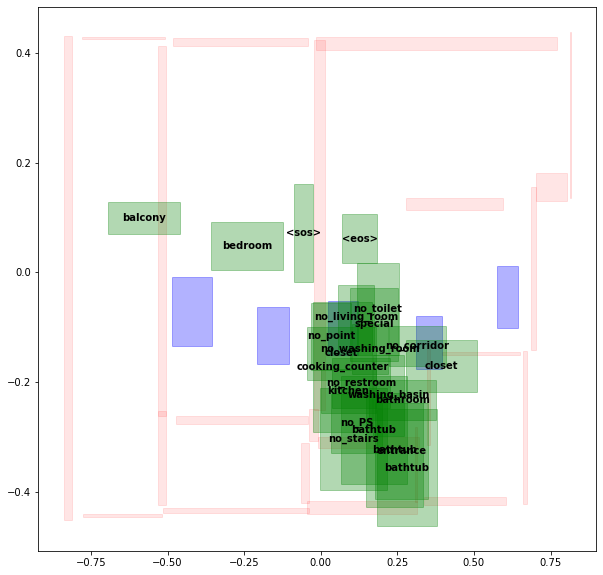

In [171]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (10,10))

c = 0
ax.plot([c, c],[c, c])
ax.autoscale()

for idx, (category) in enumerate(lst_tok):
    
    x_min_val = output_coord[0, idx, 0].detach().numpy()
    y_min_val = output_coord[0, idx, 1].detach().numpy()
    x_max_val = output_coord[0, idx, 2].detach().numpy()
    y_max_val = output_coord[0, idx, 3].detach().numpy()
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    if category == "wall":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "blue", alpha = 0.3))
    else:
        rectangle = Rectangle((x_min_val, y_min_val), w, h, color = "green", alpha = 0.3)
        ax.add_patch(rectangle)
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry + rectangle.get_height()/2.0
        ax.annotate(category, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')
plt.show()

In [173]:
lst_tok = [train_dataset.index_to_word[i] for i in batch[1][0][0,:,0].tolist()]

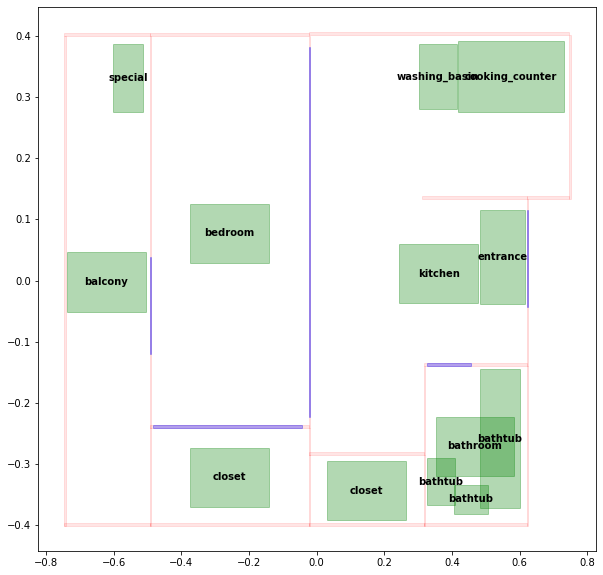

In [174]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (10,10))

c = 0
ax.plot([c, c],[c, c])
ax.autoscale()

for idx, (category) in enumerate(lst_tok):
    
    x_min_val = batch[1][1][0, idx, 0].detach().numpy()
    y_min_val = batch[1][1][0, idx, 1].detach().numpy()
    x_max_val = batch[1][1][0, idx, 2].detach().numpy()
    y_max_val = batch[1][1][0, idx, 3].detach().numpy()
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    if category == "wall":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "blue", alpha = 0.3))
    elif "no_" in category or "<" in category:
        pass
    else:
        rectangle = Rectangle((x_min_val, y_min_val), w, h, color = "green", alpha = 0.3)
        ax.add_patch(rectangle)
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry + rectangle.get_height()/2.0
        ax.annotate(category, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

plt.show()